In [3]:
%load_ext autoreload
%autoreload 2

# standard import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from sklearn.datasets import fetch_california_housing

# miscilaneous models
import pickle
import openml
from ucimlrepo import fetch_ucirepo
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

This notebook downloads and processes data used to evaluate our uncertainty quantification method for regression. The procedure includes the following.

* Download dataset from source and document dataset context. The description of the datasets mainly comes from the site where the dataset is hosted. In the case that the description is not available, we do our best to find the origninal publication and summarize.

* One-hot encode categorical features and remove one level for each one-hot encoded feature.

Here is a brief summary of all the datasets.

| Dataset           |     n |    d |
|:------------------|------:|-----:|
| ailerons          | 13750 |   40 |
| airfoil           |  1503 |    5 |
| allstate          |  5000 | 1037 |
| ca housing        | 20640 |    8 |
| computer          |  8192 |   21 |
| concrete          |  1030 |    8 |
| diamond           | 53940 |   23 |
| elevator          | 16599 |   18 |
| energy efficiency |   768 |   10 |
| insurance         |  1338 |    8 |
| kin8nm            |  8192 |    8 |
| miami housing     | 13932 |   28 |
| naval propulsion  | 11934 |   24 |
| parkinsons        |  5875 |   18 |
| powerplant        |  9568 |    4 |
| qsar              |  5742 |  500 |
| sulfur            | 10081 |    5 |
| superconductor    | 21263 |   79 |

We also identify subgroups for each dataset from features. For each dataset, the procedure is outlined below.

1. Fit a random forest regressor over the dataset.

2. Rank the features by importance from the random forest fit.

3. Use the top 1 or 2 most important features for manual subgroup identification. The exact thresholds and descriptions of subgroup features are included on top of each dataset's processing cell.

    a. If the feature is binary or categorical, we use True/False or the categories as the subgroups.

    b. If the feature is numerical, we look at natural breaks in its distribution (e.g. between each mode if the distribution is multi-modal). If there are no natural breaks, we split the feature evenly into 4 quartiles.

4. For features that are not the most important, we form subgroups automatically. If a feature is binary or cateogrical, we follow 3a. If a feature is numerical, we split the feature into 4 quartiles.

# Utility Functions


In [4]:
def process_data(X, y, cat_feat, num_feat):
    """
    Processes the input data by performing the following steps:
    1. One-hot encodes the categorical features.
    2. Computes feature importance using a Random Forest regressor.
    3. Bins the numerical features into quantiles.
    4. Combines the binned numerical features with the categorical features.

    Parameters:
        X (pd.DataFrame): The input features dataframe.
        y (np.ndarray): The target variable array.
        cat_feat (list): List of categorical feature names.
        num_feat (np.ndarray): Array of numerical feature names.

    Returns:
        tuple: A tuple containing:
            - X_processed (pd.DataFrame): The processed features dataframe.
            - y (np.ndarray): The target variable array.
            - subgroup_dict (dict): A dictionary containing:
                - "num_feat" (np.ndarray): Array of numerical feature names.
                - "cat_feat" (np.ndarray): Array of categorical feature names.
                - "importance" (pd.DataFrame): Dataframe of feature importances.
                - "binned_df" (pd.DataFrame): Dataframe of subgroups for all features.
    """
    # one-hot encode categorical features
    X_processed = pd.get_dummies(X, columns=cat_feat, drop_first=True, dtype=int)

    # save categorical features after one-hot encoding
    cat_feat_dummy = X_processed.drop(columns=num_feat).columns.to_numpy()

    # get feature importance
    # random forest
    imp_model_rf = RandomForestRegressor(
        min_samples_leaf=5, max_features=0.33, n_estimators=100, random_state=777
    )
    feat_imp_rf = imp_model_rf.fit(X_processed, y).feature_importances_

    imp_df = pd.DataFrame(
        {
            "feature": X_processed.columns,
            "importance_rf": feat_imp_rf,
        }
    ).sort_values("importance_rf", ascending=False)

    X_binned = X_processed[num_feat].apply(
        lambda c: pd.qcut(c, q=4, duplicates="drop"), axis=0
    )

    X_binned = pd.concat([X_binned, X_processed[cat_feat_dummy]], axis=1)
            

    subgroup_dict = {
        "num_feat": num_feat,
        "cat_feat": cat_feat_dummy,
        "importance": imp_df,
        "binned_df": X_binned,
    }

    return X_processed, y, subgroup_dict

def plot_distribution(X, importance_df, importance_rank, cuts=None, bins=50, xlim=None):
    """
    Plots the distribution of a feature based on its importance rank.

    Parameters:
        X (pd.DataFrame): The input features dataframe.
        importance_df (pd.DataFrame): The dataframe containing feature importances.
        importance_rank (int): The rank of the feature based on its importance.
        cuts (str or list, optional): The cut points to define the bins for the feature. If 'quantiles', the feature will be split into quantiles.
        bins (int, optional): The number of bins for the histogram. Default is 50.
        xlim (tuple, optional): The x-axis limits for the plot.

    Returns:
        None
    """

    feature_name = importance_df["feature"].iloc[int(importance_rank - 1)]
    print(f"Feature with importance rank {importance_rank}: {feature_name}")
    if X[feature_name].nunique() == 2: # binary feature
        sns.countplot(x=feature_name, data=X)
        plt.title(f"Distribution of {feature_name}")
        plt.show()
        return
    else: # continuous feature
        if cuts == 'quantiles':
            cuts = round(X[feature_name].quantile([0, 0.25, 0.5, 0.75, 1]), 5).values
        plt.hist(X[feature_name], bins=bins)
        cuts = np.array(cuts)[1:-1]
        for cut in cuts:
            plt.axvline(x=cut, color='r', linestyle='--')
        plt.xlabel(feature_name)
        plt.ylabel("Count")
        plt.title(f"Distribution of {feature_name} with cuts at {cuts}")
        if xlim is not None:
            plt.xlim(xlim[0], xlim[1])
        plt.show()
        return

def modify_subgroups(X, subgroup_df, importance_df, importance_rank, cuts, print_proportion=True):
    """
    Modifies the subgroups for a given feature based on its importance rank and specified cut points.

    Parameters:
        X (pd.DataFrame): The input features dataframe.
        subgroup_df (pd.DataFrame): The dataframe containing subgroups for all features.
        importance_df (pd.DataFrame): The dataframe containing feature importances.
        importance_rank (int): The rank of the feature based on its importance.
        cuts (list): The cut points to define the bins for the feature.
        print_proportion (bool, optional): Whether to print the proportion of observations in each subgroup. Default is True.

    Returns:
        pd.DataFrame: The modified subgroup dataframe with updated bins for the specified feature.
    """
    feature_name = importance_df["feature"].iloc[int(importance_rank - 1)]
    subgroup_df = subgroup_df.copy(deep=True)
    subgroup_df[feature_name] = pd.cut(X[feature_name], bins=cuts)
    if print_proportion:
        print_proportion_subgroups(subgroup_df, feature_name)
    return subgroup_df

def print_proportion_subgroups(subgroup_df, feature_name):
    """
    Prints the proportion of observations in each subgroup for a given feature.

    Parameters:
        subgroup_df (pd.DataFrame): The dataframe containing subgroups for all features.
        feature_name (str): The name of the feature.

    Returns:
        None
    """
    print(f"Proportion of observations in each subgroup for feature {feature_name}:")
    print(subgroup_df[feature_name].value_counts(normalize=True))
    print("")
    return

def save_data(X, y, subgroup, dir_path):
    """
    Saves the processed data to a specified directory.

    Parameters:
        X (pd.DataFrame): The processed features dataframe.
        y (np.ndarray): The target variable array.
        subgroup (dict): A dictionary containing subgroup information.
        dir_path (str): The directory path where the data will be saved.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    X.to_csv(os.path.join(dir_path, "X.csv"), index=False)
    np.savetxt(os.path.join(dir_path, "y.csv"), y, delimiter=',')

    importances = subgroup["importance"]
    importances.to_csv(os.path.join(dir_path, "importances.csv"), index=False)

    bin_df = subgroup["binned_df"]
    save_pickle(bin_df, os.path.join(dir_path, "bin_df.pkl"))
    print("Data saved successfully.")

def save_pickle(file, path):
    """
    Saves a file to a specified path using pickle.

    Parameters:
        file (object): The file to be saved.
        path (str): The path where the file will be saved
    """
    file_pickled = pickle.dumps(file)
    with open(path, "wb") as f:
        f.write(file_pickled)
    return None

# Datasets

## Ailerons

[dataset link](https://www.openml.org/search?type=data&id=296&sort=runs&status=active)

### Dataset Information

This dataset is obtained from records of flying a F16 aircraft. The attributes describe the status of the aeroplane, while the goal is to predict the control action on the ailerons of the aircraft.

### Subgroup Information

We manually form subgroups based on the feature `absRoll`. No description of the feature was availabel. The distribution of the feature shows 3 modes, at roughly -18, -11, and -7, so we form the subgroups by breaking between the modes.

#### Reference

Luis Torgo. Ailerons [Dataset]. Collection of Regression Datasets. https://www.dcc.fc.up.pt/~ltorgo/Regression/ailerons.html.

Feature with importance rank 1: absRoll


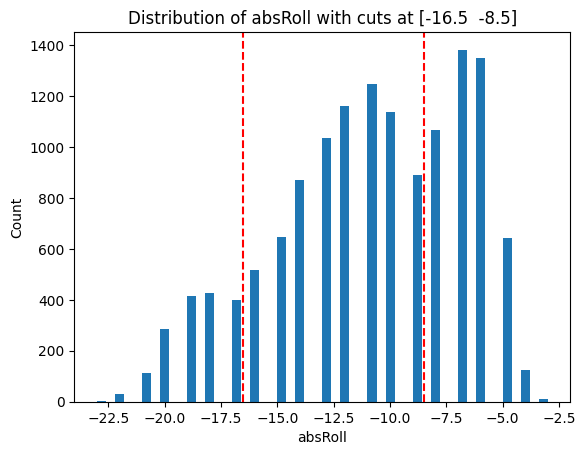

Proportion of observations in each subgroup for feature absRoll:
absRoll
(-16.5, -8.5]     0.546036
(-8.5, 0.0]       0.332655
(-24.0, -16.5]    0.121309
Name: proportion, dtype: float64

Data saved successfully.


In [5]:
data = "data_ailerons"

# download dataset
ailerons = openml.datasets.get_dataset(296)
X_orig, y, cat_ind, col_names = ailerons.get_data(target=ailerons.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

# save categorical and numerical features
cat_feat_ailerons = np.array(col_names)[cat_ind].tolist()
num_feat_ailerons = X_orig.drop(columns=cat_feat_ailerons).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_ailerons, num_feat_ailerons)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[-24, -16.5, -8.5, 0])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[-24, -16.5, -8.5, 0]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Airfoil


[dataset link](https://archive.ics.uci.edu/dataset/291/airfoil+self+noise)

### Dataset Information

NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel. 

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. The goal is to predict the scaled sound pressure level, measured in decibels.

### Subgroup information

We manually form subgroups based on the feature `frequency`, which is the frequency of the noise produced from the airblades, measured in Hertzs. We separete the body and the right tail of the distribution.

#### Reference

Brooks, T., Pope, D., & Marcolini, M. (1989). Airfoil Self-Noise [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5VW2C.

Feature with importance rank 1: frequency


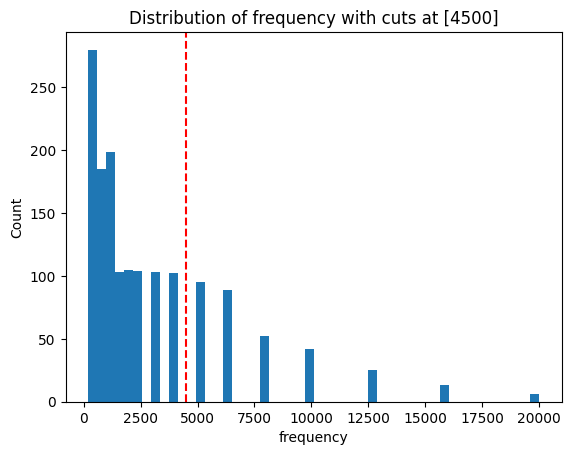

Proportion of observations in each subgroup for feature frequency:
frequency
(0, 4500]        0.785762
(4500, 20000]    0.214238
Name: proportion, dtype: float64

Data saved successfully.


In [6]:
data = "data_airfoil"

# download dataset
airfoil_self_noise = fetch_ucirepo(id=291)
X_orig = airfoil_self_noise.data.features
y = airfoil_self_noise.data.targets["scaled-sound-pressure"].to_numpy()

# save categorical and numerical features
cat_feat_airfoil = []
num_feat_airfoil = X_orig.drop(columns=cat_feat_airfoil).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_airfoil, num_feat_airfoil)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 4500, 20000])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 4500, 20000]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Allstate


[dataset link](https://www.openml.org/search?type=data&id=42571&sort=runs&status=active)

### Dataset Information

This dataset contains information from the insurance company Allstate. Each observation is a single insurance claim. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous. The goal is the predict the loss in the insurance claim, which is a measurement of claim severity. We subsample the dataset to 5000 observations.

### Subgroup Information

We manually form subgroups based on the feature `cat79_D`, which is a binary feature. The description of the feature is unknown since the dataset is anonymized.

#### Reference

de Paula Bueno, M. (2020). Allstate_Claims_Severity [Dataset]. OpenML Datasets. https://www.openml.org/search?type=data&id=42571&sort=runs&status=active.

Feature with importance rank 1: cat79_D


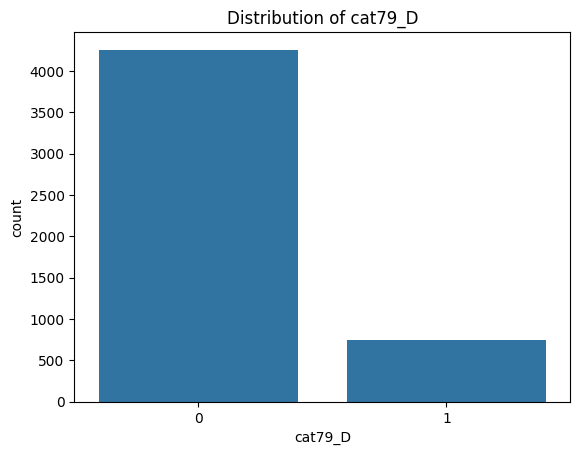

Proportion of observations in each subgroup for feature cat79_D:
cat79_D
0    0.851
1    0.149
Name: proportion, dtype: float64

Data saved successfully.


In [7]:
data = "data_allstate"

# download dataset
allstate = openml.datasets.get_dataset(42571)
X_orig, y, cat_ind, col_names = allstate.get_data(
    target=allstate.default_target_attribute, dataset_format="dataframe"
)
y = y.to_numpy()

# save categorical and numerical features
cat_feat_allstate = np.array(col_names)[cat_ind].tolist()
num_feat_allstate = X_orig.drop(columns=cat_feat_allstate).columns.to_numpy()

# process dataset
X_orig, y = resample(X_orig, y, replace=False, n_samples=5000, random_state=777) # subsample data
X, y, subgroups = process_data(X_orig, y, cat_feat_allstate, num_feat_allstate)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1)

# 2. manually modify discovered subgroups
# no modifications needed for this dataset since the top feature is binary
print_proportion_subgroups(subgroups["binned_df"], "cat79_D")

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")


## California Housing


[dataset link](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)

### Dataset Information

The dataset is collected from the 1990 US Census. Each observation contains housing information on a single census block group in California. The goal is to predict the median price of houses in the block group.

### Subgroup Information

We manually form subgroups based on the feature `med_income`, which is the median income in the block group, measured in tens of thousands of dollars. We separate the body of the distribution from the right tail. In the right tail, we observe 2 smaller modes at 7.5 and 10.5, so we break between those 2 modes as well.

#### Reference

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.

Feature with importance rank 1: med_income


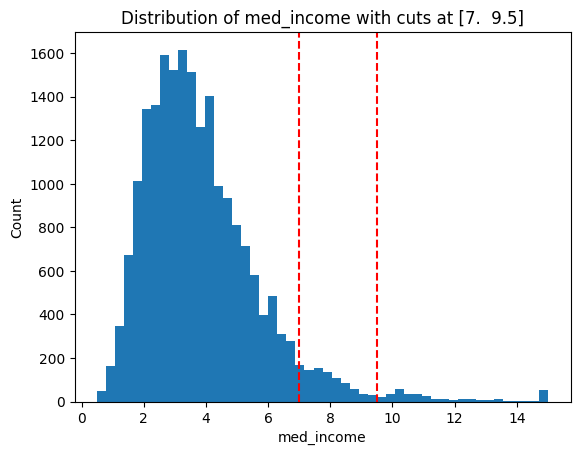

Proportion of observations in each subgroup for feature med_income:
med_income
(0.0, 7.0]     0.944150
(7.0, 9.5]     0.041134
(9.5, 15.0]    0.014715
Name: proportion, dtype: float64

Data saved successfully.


In [24]:
data = "data_ca_housing"

# download dataset
housing = pd.read_csv("../data/datasets/cal_housing.data", delimiter=",", names = ["lon", "lat", "med_age", "total_rooms", "total_beds", "population", "households", "med_income", "med_price"])
X_orig = housing.drop(columns="med_price")
y = housing.med_price.to_numpy()

# save categorical and numerical features
cat_feat_ca_housing = []
num_feat_ca_housing = X_orig.drop(columns = cat_feat_ca_housing).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_ca_housing, num_feat_ca_housing)
bin_df = subgroups["binned_df"]
bin_df['med_income'] = pd.cut(X['med_income'], [0, 7, 9.5, 15])

# manually modify discovered subgroups
# 1. investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 7, 9.5, 15])

# 2. modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 7, 9.5, 15]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Computer

[dataset link](https://www.openml.org/search?type=data&status=active&id=197&sort=runs)

### Dataset Information

The Computer Activity databases are a collection of computer systems activity measures. The data was collected from a Sun Sparcstation 20/712 with 128 Mbytes of memory running in a multi-user university department. Users would typically be doing a large variety of tasks ranging from accessing the internet, editing files or running very cpu-bound programs. The data was collected continuously on two separate occasions. On both occassions, system activity was gathered every 5 seconds. The final dataset is taken from both occasions with equal numbers of observations coming from each collection epoch. The goal is to predict the proportion of time that cpus run in user mode, in percents.

### Subgroup Information

We manually form subgroups based on the feature `freeswap`, which is the number of disk blocks available for page swapping. We first separate the outliers at zero. Then we separate the feature at the gap at 1200000.

#### Reference

Luis Torgo. Computer Activity [Dataset]. Collection of Regression Datasets. https://www.dcc.fc.up.pt/~ltorgo/Regression/comp.html.

Feature with importance rank 1: freeswap


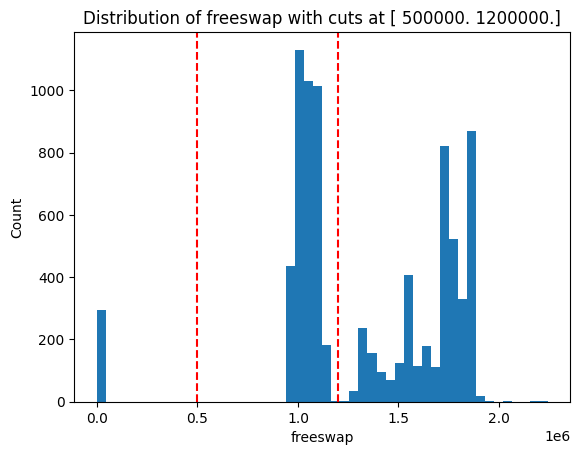

Proportion of observations in each subgroup for feature freeswap:
freeswap
(1200000.0, 3000000.0]    0.500854
(500000.0, 1200000.0]     0.463257
(0.0, 500000.0]           0.035889
Name: proportion, dtype: float64

Data saved successfully.


In [10]:
data = "data_computer"

# download dataset
computer = openml.datasets.get_dataset(197)
X_orig, y, cat_ind, col_names = computer.get_data(
    target=computer.default_target_attribute, dataset_format="dataframe"
)
y = y.to_numpy()

# save categorical and numerical features
cat_feat_computer = []
num_feat_computer = X_orig.drop(columns=cat_feat_computer).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_computer, num_feat_computer)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 0.5*10**6, 1.2*10**6, 3*10**6])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 0.5*10**6, 1.2*10**6, 3*10**6]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Concrete

[dataset link](https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength)

### Dataset Information

Concrete is the most important material in civil engineering. The dataset contains measurements of different concrete blocks. The goal is to predict the concrete compressive strength, measured in MPa.

### Subgroup Information

We manually form subgroups based on the feature `Age`, which is the age of the concrete block, measured in days. We separate the body of the distribution with the right tail at 50.

#### Reference

Yeh, I. (1998). Concrete Compressive Strength [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5PK67.

Feature with importance rank 1: Age


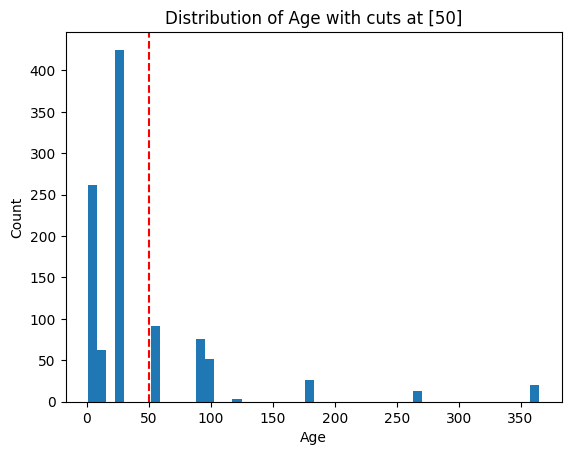

Proportion of observations in each subgroup for feature Age:
Age
(0, 50]      0.727184
(50, 400]    0.272816
Name: proportion, dtype: float64

Data saved successfully.


In [11]:
data = "data_concrete"

# download dataset
concrete_compressive_strength = fetch_ucirepo(id=165)
X_orig = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets[
    "Concrete compressive strength"
].to_numpy()

# save categorical and numerical features
cat_feat_concrete = []
num_feat_concrete = X_orig.drop(columns=cat_feat_concrete).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_concrete, num_feat_concrete)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 50, 400])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 50, 400]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Diamond


[dataset link](https://openml.org/search?type=data&sort=version&status=any&order=asc&exact_name=diamonds&id=42225)

### Dataset Information:

This classic dataset contains the prices and other attributes of almost 54,000 diamonds. The goal is to predict the price of the diamond, in dollars.

### Subgroup Information:

We manually form subgroups based on the feature `y`, which is the y width of the diamond, measured in millimeters. The distribution shows 6 modes. So we group the 2 modes in the left tail and the 2 modes in the middle of the distribution. Since the right tail is heavier than the left tail, we separate the 2 modes in the right tail into their own groups.

#### Reference

Muller, A. (2019). diamonds [Dataset]. OpenML Datasets. https://openml.org/search?type=data&sort=version&status=any&order=asc&exact_name=diamonds&id=42225.

Feature with importance rank 1: y


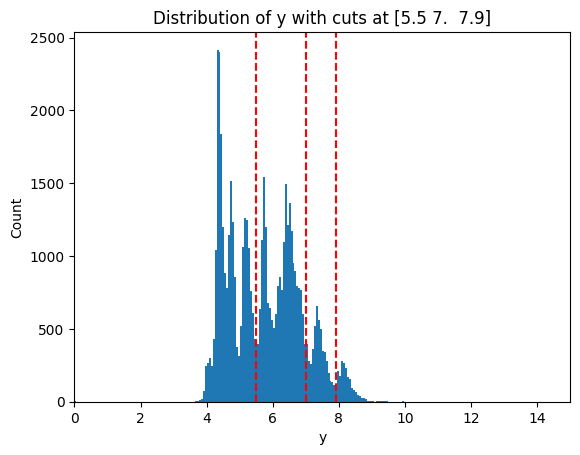

Proportion of observations in each subgroup for feature y:
y
(-0.001, 5.5]    0.459659
(5.5, 7.0]       0.407582
(7.0, 7.9]       0.094642
(7.9, 60.0]      0.038116
Name: proportion, dtype: float64

Data saved successfully.


In [12]:
data = "data_diamond"

# download dataset
diamond = openml.datasets.get_dataset(42225)
X_orig, y, cat_ind, col_names = diamond.get_data(target=diamond.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

# save categorical and numerical features
cat_feat_diamond = np.array(col_names)[cat_ind].tolist()
num_feat_diamond = X_orig.drop(columns = cat_feat_diamond).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_diamond, num_feat_diamond)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[-0.001, 5.5, 7.0, 7.9, 60], bins=1000, xlim=(0, 15))

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[-0.001, 5.5, 7.0, 7.9, 60]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Elevators

[dataset link](https://www.openml.org/search?type=data&id=216&sort=runs&status=active)

### Dataset Information

This dataset is obtained from the task of controlling a F16 aircraft. The goal is related to an action taken on the elevators of the aircraft.

### Subgroup Information

We manually form subgroups based on the feature `SaTime1`. No description of the feature was availabel. Since the distribution of the feature rises smoothly, we decided to cut this feature into 4 quartiles. This results in the body of the distribution being broken into 3 parts, and the left tail is separated.

#### Reference

Luis Torgo. Elevators [Dataset]. Collection of Regression Datasets. https://www.dcc.fc.up.pt/~ltorgo/Regression/elevators.html.

Feature with importance rank 1: SaTime1


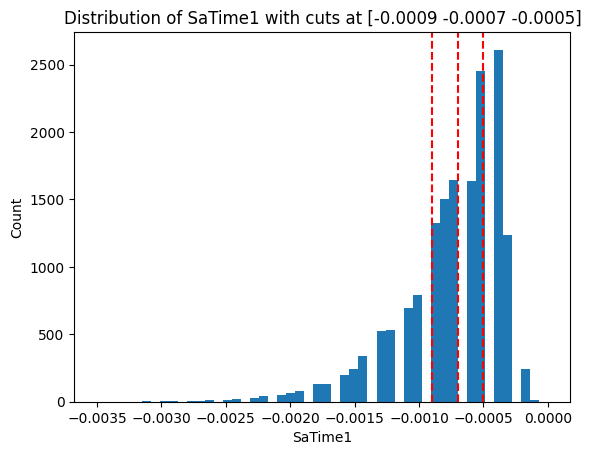

Data saved successfully.


In [13]:
data = "data_elevator"

# download dataset
elevator = openml.datasets.get_dataset(216)
X_orig, y, cat_ind, col_names = elevator.get_data(target=elevator.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

# save categorical and numerical features
cat_feat_elevator = np.array(col_names)[cat_ind].tolist()
num_feat_elevator = X_orig.drop(columns=cat_feat_elevator).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_elevator, num_feat_elevator)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts='quantiles')

# 2. manually modify discovered subgroups
# There is no natual breaks in the distribution of the top feature
# so we will cut the feature into 4 quantiles (default behavior)

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Energy Efficiency

[dataset link](https://archive.ics.uci.edu/dataset/242/energy+efficiency)

### Dataset Information

This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters. The goal is to predict the heating load (units unknown).

### Subgroup Information

We manually form subgroups based on the feature `Roof_Area`, which is the area of the roof of the buildings (units unknown). The distribution seems to concentrate on 4 values. We group the 3 values that are closer together and separate the fourth area.

#### Reference

Tsanas, A. & Xifara, A. (2012). Energy Efficiency [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C51307.

Feature with importance rank 1: Roof_Area


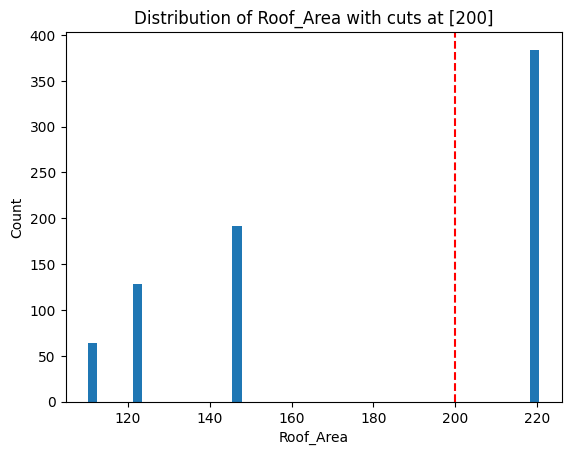

Proportion of observations in each subgroup for feature Roof_Area:
Roof_Area
(0, 200]      0.5
(200, 400]    0.5
Name: proportion, dtype: float64

Data saved successfully.


In [14]:
data = "data_energy_efficiency"
# download dataset 
energy_efficiency = fetch_ucirepo(id=242) 
X_orig = energy_efficiency.data.features 
y_orig = energy_efficiency.data.targets 
y = y_orig.Y1.to_numpy()

# rename columns
X_orig.columns = [
    'Relative_Compactness',
    'Surface_Area',
    'Wall_Area',
    'Roof_Area',
    'Overall_Height',
    'Orientation',
    'Glazing_Area',
    'Glazing_Area_Distribution'
]

# save categorical and numerical features
cat_feat = ['Orientation']
num_feat = X_orig.drop(columns=cat_feat).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat, num_feat)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 200, 400])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 200, 400]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Insurance

[dataset link](https://github.com/pycaret/pycaret/blob/master/datasets/insurance.csv)

### Dataset Information

The dataset contains information on insurance customers. The goal is to predict the insurance premium in dollars.

### Subgroup Information

We manually form subgroups based on the feature `smoker_yes`, which is a binary feature on whether the customer is a smoker (0 means non-smoker and 1 means smoker).

#### Reference

Ali, M. (2020). PyCaret: An open source, low-code machine learning library in Python. Retrieved from https://www.pycaret.org

Feature with importance rank 1: smoker_yes


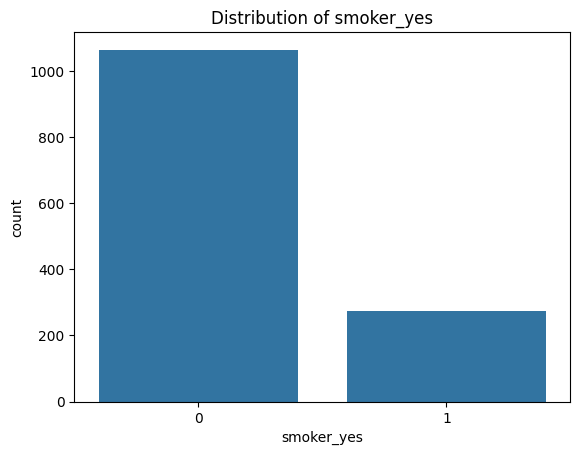

Proportion of observations in each subgroup for feature smoker_yes:
smoker_yes
0    0.795217
1    0.204783
Name: proportion, dtype: float64

Data saved successfully.


In [15]:
data = "data_insurance"

# download dataset
insurance = pd.read_csv(
    "https://raw.githubusercontent.com/pycaret/datasets/main/data/common/insurance.csv"
)
X_orig = insurance.drop(columns="charges")
y = insurance.charges.to_numpy()

# save categorical and numerical features
cat_feat_insurance = ["sex", "smoker", "region"]
num_feat_insurance = X_orig.drop(columns=cat_feat_insurance).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_insurance, num_feat_insurance)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1)

# 2. manually modify discovered subgroups
# no modifications needed for this dataset since the top feature is binary
print_proportion_subgroups(subgroups["binned_df"], "smoker_yes")

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## kin8nm


[dataset link](https://www.openml.org/search?type=data&sort=runs&id=189&status=active)

### Dataset Information

This is data set is concerned with the forward kinematics of an 8 link robot arm. Among the existing variants of this data set we have used the variant 8nm, which is known to be highly non-linear and medium noisy. The goal is to predict the distance of the end-effector (unit unknown).

### Subgroup Information

The top feature is `theta3`, which has a near-uniform distribution, thus has no natural breaks. We form the subgroups by breaking the feature into 4 quantiles.

#### Reference

Luis Torgo. Kinematics [Dataset]. Collection of Regression Datasets. https://www.dcc.fc.up.pt/~ltorgo/Regression/kin.html.

Feature with importance rank 1: theta3


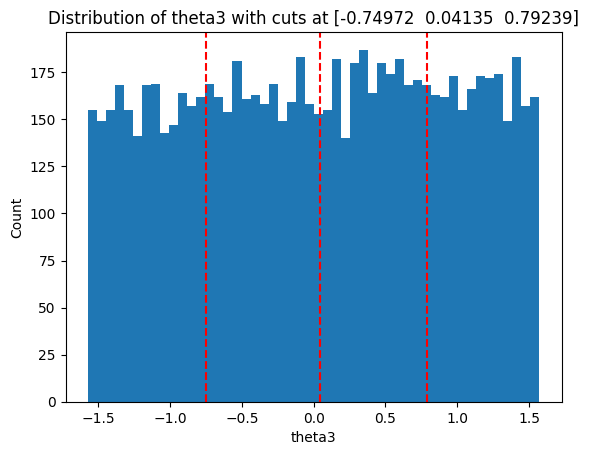

Proportion of observations in each subgroup for feature theta3:
theta3
(-1.5719999999999998, -0.75]    0.25
(-0.75, 0.0413]                 0.25
(0.0413, 0.792]                 0.25
(0.792, 1.571]                  0.25
Name: proportion, dtype: float64

Data saved successfully.


In [16]:
data = "data_kin8nm"

# download dataset
kin8nm = openml.datasets.get_dataset(189)
X_orig, y, _, _ = kin8nm.get_data(target=kin8nm.default_target_attribute)

# save categorical and numerical features
cat_feat = []
num_feat = X_orig.drop(columns=cat_feat).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat, num_feat)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts='quantiles')

# 2. manually modify discovered subgroups
# There is no natual breaks in the distribution of the top feature
# so we will cut the feature into 4 quantiles (default behavior)
print_proportion_subgroups(subgroups["binned_df"], "theta3")

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Miami Housing

[dataset link](https://www.openml.org/search?type=data&status=active&id=43093&sort=runs)

### Dataset Information

The dataset contains information on 13,932 single-family homes sold in Miami. The goal is to predict the price of the home at sale, in dollars.

### Subgroup Information

We manually form 2 sets of subgroups based on the two features with the highest feature importances.

- `TOT_LVG_AREA`: The floor area of the home, in square feet. Besides the main mode at 1500, there is a small mode at 3000 that extends into the right tail. So we separate the body of the distribution from the right tail.

- `OCEAN_DIST`: Distance to nearest ocean, in feet. There are 2 modes in the distribution at 20000 and 58000, so we break between the two modes.

#### Reference

Steven Bourassa. (2021). MiamiHousing2016 [Dataset]. OpenML Datasets. https://www.openml.org/search?type=data&status=active&id=43093&sort=runs.

Feature with importance rank 1: TOT_LVG_AREA


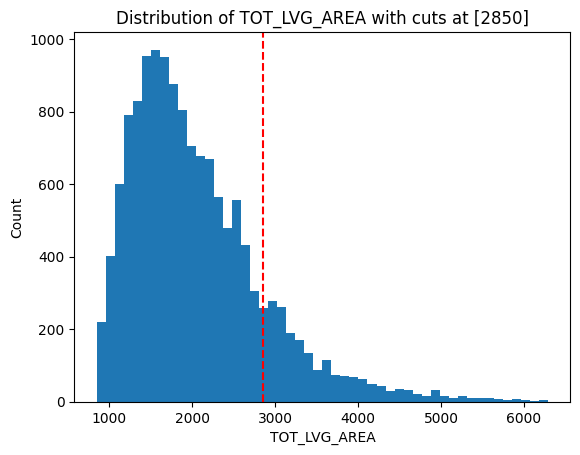

Feature with importance rank 2: OCEAN_DIST


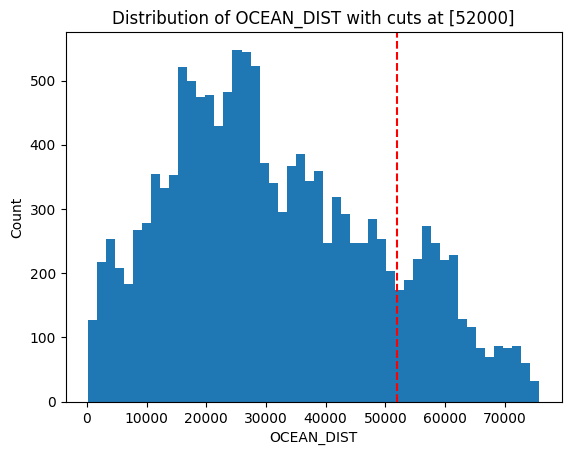

Proportion of observations in each subgroup for feature TOT_LVG_AREA:
TOT_LVG_AREA
(0, 2850]        0.854651
(2850, 10000]    0.145349
Name: proportion, dtype: float64

Proportion of observations in each subgroup for feature OCEAN_DIST:
OCEAN_DIST
(0, 52000]        0.839076
(52000, 80000]    0.160924
Name: proportion, dtype: float64

Data saved successfully.


In [17]:
data = "data_miami_housing"

# download dataset
miami_housing = openml.datasets.get_dataset(43093)
X_orig, y, cat_ind, col_names = miami_housing.get_data(
    target=miami_housing.default_target_attribute, dataset_format="dataframe"
)
X_orig = X_orig.drop(columns="PARCELNO").reset_index(drop=True) # drop parcel number (unique identifier)
y = y.to_numpy()

# save categorical and numerical features
cat_feat_miami_housing = ["avno60plus", "month_sold", "structure_quality"]
num_feat_miami_housing = X_orig.drop(columns=cat_feat_miami_housing).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(
    X_orig, y, cat_feat_miami_housing, num_feat_miami_housing
)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 2850, 10000])
plot_distribution(X, subgroups["importance"], importance_rank=2, cuts=[0, 52000, 80000])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 2850, 10000]
)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=2, cuts=[0, 52000, 80000]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")


## Naval Propulsion


[dataset link](https://archive.ics.uci.edu/dataset/316/condition+based+maintenance+of+naval+propulsion+plants)

### Dataset Information

Data have been generated from a sophisticated simulator of a Gas Turbines (GT), mounted on a Frigate characterized by a COmbined Diesel eLectric And Gas (CODLAG) propulsion plant type. The goal is to predict the fuel flow, measured in kilograms per second.

### Subgroup Information

We manually form subgroups based on the feature `Gas_Turbine_rate_of_revolutions`, which is the rate of revolutions of the gas turbine, measured in revolutions per minute. The distribution seems uniform, except for the initial peak at 1500. We separate the initial peak and evenly divide the rest of the distribution into halves.

#### Reference

Coraddu, A., Oneto, L., Ghio, A., Savio, S., Anguita, D., & Figari, M. (2014). Condition Based Maintenance of Naval Propulsion Plants [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K31K.

Feature with importance rank 1: Turbine_Injection_Control


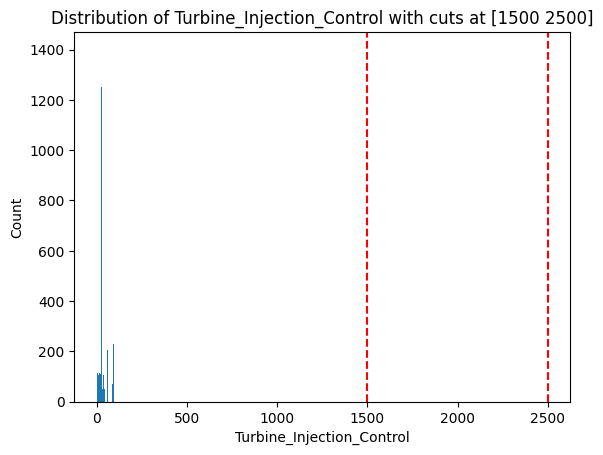

Proportion of observations in each subgroup for feature Turbine_Injection_Control:
Turbine_Injection_Control
(0, 1500]       1.0
(1500, 2500]    0.0
(2500, 4000]    0.0
Name: proportion, dtype: float64

Data saved successfully.


In [25]:
data = 'data_naval_propulsion'

# download dataset
column_names = ['Lever_position', 'Ship_speed', 'Gas_Turbine_shaft_torque', 
                'Gas_Turbine_rate_of_revolutions', 'Gas_Generator_rate_of_revolutions',
                'Starboard_Propeller_Torque', 'Port_Propeller_Torque', 
                'HP_Turbine_exit_temperature', 'GT_Compressor_inlet_air_temperature', 
                'GT_Compressor_outlet_air_temperature', 'HP_Turbine_exit_pressure',
                'GT_Compressor_inlet_air_pressure', 'GT_Compressor_outlet_air_pressure', 
                'Gas_Turbine_exhaust_gas_pressure', 'Turbine_Injection_Control',
                'Fuel_flow', 'GT_Compressor_decay_state_coefficient', 'GT_Turbine_decay_state_coefficient']

naval_propulsion = pd.read_csv("../data/datasets/naval_propulsion.txt", delim_whitespace=True, header=None, names=column_names)
X_orig = naval_propulsion.drop(columns=['Fuel_flow'])
y = naval_propulsion[['Fuel_flow']].values.ravel()

# save categorical and numerical features
cat_feat = ['Ship_speed']
num_feat = X_orig.drop(columns=cat_feat).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat, num_feat)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 1500, 2500, 4000])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 1500, 2500, 4000]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")


## Parkinsons


[dataset link](https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring)

### Dataset Information

This dataset is composed of a range of biomedical voice measurements from people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. The main aim of the data is to predict the total UPDRS scores.

### Subgroup information

We manually form 2 sets of subgroups based on the two features with the highest feature importances.

- `Age`: The age of the Parkinson's patient, measured in years. We observe 3 modes in the distribution (at 55, 65, and 72) and a separate group of outliers on the left tail. So we isolate the left tail and also break between the 3 modes.

- `DFA`: Detrended Fluctuation Analysis, a measurement of the extent of turbulent noise in the speech signal. We observe 2 modes in the distribution at 0.6 and 0.72, so we break between the 2 modes.

#### Reference

Tsanas, A. & Little, M. (2009). Parkinsons Telemonitoring [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5ZS3N.

Feature with importance rank 1: age


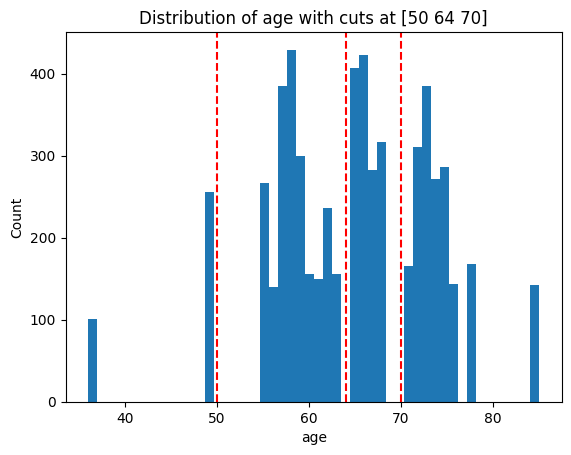

Feature with importance rank 2: DFA


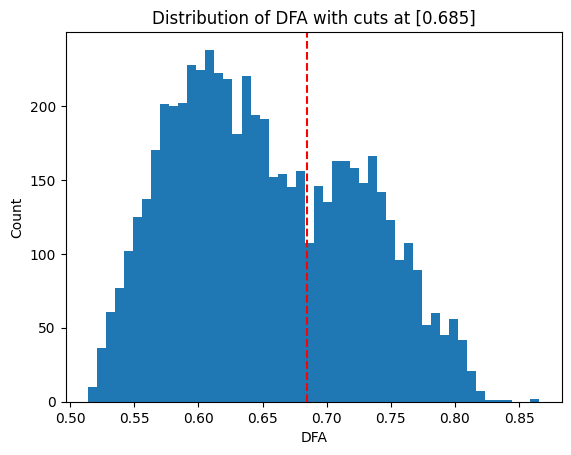

Proportion of observations in each subgroup for feature age:
age
(50, 64]     0.377532
(70, 100]    0.318468
(64, 70]     0.243234
(0, 50]      0.060766
Name: proportion, dtype: float64

Proportion of observations in each subgroup for feature DFA:
DFA
(0.0, 0.685]    0.661106
(0.685, 1.0]    0.338894
Name: proportion, dtype: float64

Data saved successfully.


In [19]:
data = "data_parkinsons"

# download dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)
X_orig = parkinsons_telemonitoring.data.features.drop(columns="test_time")
y = parkinsons_telemonitoring.data.targets.total_UPDRS.to_numpy()

# save categorical and numerical features
cat_feat_parkinsons = ["sex"]
num_feat_parkinsons = X_orig.drop(columns=cat_feat_parkinsons).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_parkinsons, num_feat_parkinsons)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 50, 64, 70, 100])
plot_distribution(X, subgroups["importance"], importance_rank=2, cuts=[0, 0.685, 1])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 50, 64, 70, 100]
)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=2, cuts=[0, 0.685, 1]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Powerplant


[dataset link](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant)

### Dataset Information

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance. The goal is to predict the net hourly electrical energy output (EP)  of the plant.

### Subgroup Information

We manually form subgroups based on the feature `AT`, which is the hourly average ambient temperature, measured in degrees Celcius. The distribution has 2 modes at 13 and 25, so we break between the two modes.

#### Reference

Tfekci, P. & Kaya, H. (2014). Combined Cycle Power Plant [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5002N.

Feature with importance rank 1: AT


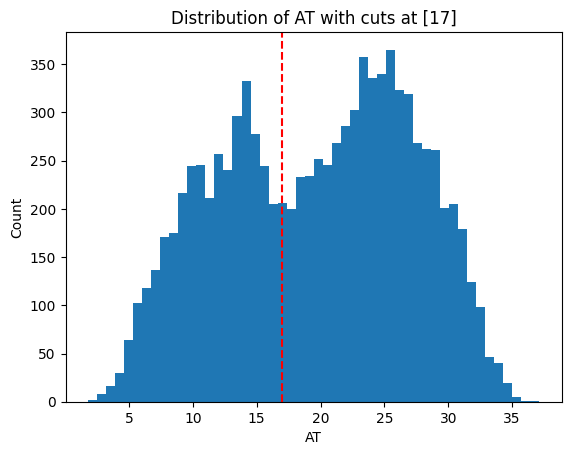

Proportion of observations in each subgroup for feature AT:
AT
(17, 40]    0.612458
(0, 17]     0.387542
Name: proportion, dtype: float64

Data saved successfully.


In [20]:
data = "data_powerplant"

# download dataset
combined_cycle_power_plant = fetch_ucirepo(id=294)
X_orig = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets.PE.to_numpy()

# save categorical and numerical features
cat_feat_powerplant = []
num_feat_powerplant = X_orig.drop(columns=cat_feat_powerplant).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_powerplant, num_feat_powerplant)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[0, 17, 40])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[0, 17, 40]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## QSAR


[dataset link](https://www.openml.org/search?type=data&id=3050&sort=runs&status=active)

### Dataset Information

This dataset contains QSAR data (from ChEMBL version 17) showing activity values (unit is pseudo-pCI50) of several compounds on drug target TID: 11, and it has 5742 rows and 1024 features. The features represent FCFP 1024bit Molecular Fingerprints which were generated from SMILES strings. They were obtained using the Pipeline Pilot program, Dassault Systèmes BIOVIA. To perform feature selection, we select the top 500 features with the highest variance.

### Subgroup Information

We manually form subgroups based on the feature `FCFP6_1024_652_1.0`, which is a binary feature on whether a specific component of the chemical compound structure is active (0 means inactive and 1 means active).

#### Reference
Olier, I., Besnard, J., Sadawi, N., Soldatova, L., Grosan, C., King, R., Bickerton, R., Hopkins, A., & van Hoorn, W. (2015). QSAR-TID-11 [Dataset]. OpenML Datasets. https://www.openml.org/search?type=data&id=3050&sort=runs&status=active.

Feature with importance rank 1: FCFP6_1024_652_1.0


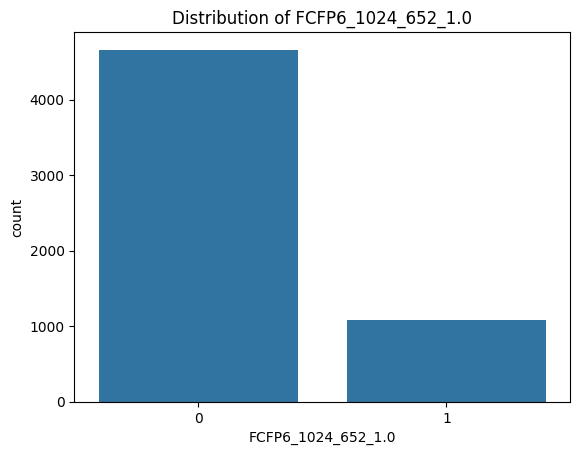

Proportion of observations in each subgroup for feature FCFP6_1024_652_1.0:
FCFP6_1024_652_1.0
0    0.811738
1    0.188262
Name: proportion, dtype: float64

Data saved successfully.


In [21]:
data = "data_qsar"

# download dataset
qsar = openml.tasks.get_task(360932)
X_orig, y = qsar.get_X_and_y(dataset_format="dataframe")
y = y.to_numpy()

# select features with variance
k = 500
X_array = X_orig.to_numpy()
top_k_columns = X_orig.columns[np.argsort(np.var(X_array, axis=0))[-k:]]
X_orig = X_orig[top_k_columns]

# save categorical and numerical features
cat_feat_qsar = X_orig.columns.tolist()
num_feat_qsar = X_orig.drop(columns=cat_feat_qsar).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_qsar, num_feat_qsar)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1)

# 2. manually modify discovered subgroups
# no modifications needed for this dataset since the top feature is binary
print_proportion_subgroups(subgroups["binned_df"], "FCFP6_1024_652_1.0")

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Sulfur

[dataset link](https://www.openml.org/search?type=data&id=23515&sort=runs&status=active)

### Dataset Information

The sulfur recovery unit (SRU) removes environmental pollutants from acid gas streams before they are released into the atmosphere. Furthermore, elemental sulfur is recovered as a valuable by-product. 5 inputs variables are gas and air flows. The goal is to predict the $SO_2$ concentration (units unknown).

### Subgroup Information

We manually form subgroups based on the feature `a1`, which is the gas flow (units unknown). The distribution of the feature shows 5 modes that are cleanly separated, at roughly 0.25, 0.4, 0.5, 0.65, and 0.85, so we form the subgroups by breaking between the modes.

#### Reference

Fortuna, L., Graziani, S., Rizzo, A., & Maria Gabriella Xibilia. (2009). Soft Sensors for Monitoring and Control of Industrial Processes. Springer.

Feature with importance rank 1: a1


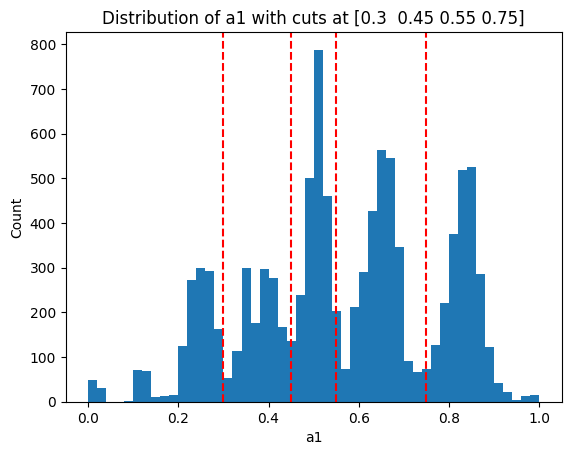

Proportion of observations in each subgroup for feature a1:
a1
(0.55, 0.75]     0.271104
(0.75, 1.0]      0.229144
(0.45, 0.55]     0.216645
(0.3, 0.45]      0.143141
(-0.001, 0.3]    0.139966
Name: proportion, dtype: float64

Data saved successfully.


In [19]:
data = "data_sulfur"

# download dataset
sulfur = openml.datasets.get_dataset(23515)
X_orig, y, cat_ind, col_names = sulfur.get_data(target=sulfur.default_target_attribute, dataset_format="dataframe")
X_orig = X_orig.drop(columns="y2")

# save categorical and numerical features
cat_feat_sulfur = np.array(col_names)[cat_ind].tolist()
num_feat_sulfur = X_orig.drop(columns=cat_feat_sulfur).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_sulfur, num_feat_sulfur)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[-0.001, 0.3, 0.45, 0.55, 0.75, 1])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[-0.001, 0.3, 0.45, 0.55, 0.75, 1]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")

## Superconductor

[dataset link](https://openml.org/search?type=data&sort=version&status=any&order=asc&exact_name=superconduct&id=44148)

### Dataset Information

The data contains information on 21263 superconductors. The goal is to predict the critical temperature, measured in Kelvins.

### Subgroup Information

We manually form subgroups based on the feature `range_ThermalConductivity`, which is the unweighted range of thermal conductivity of the material, measured in Watts per minute-Kelvin. The distribution has a mode at 400, so we seprate the mode from the left tail.

#### Reference

Hamidieh, K. (2018). Superconductivty Data [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53P47.

Feature with importance rank 1: range_ThermalConductivity


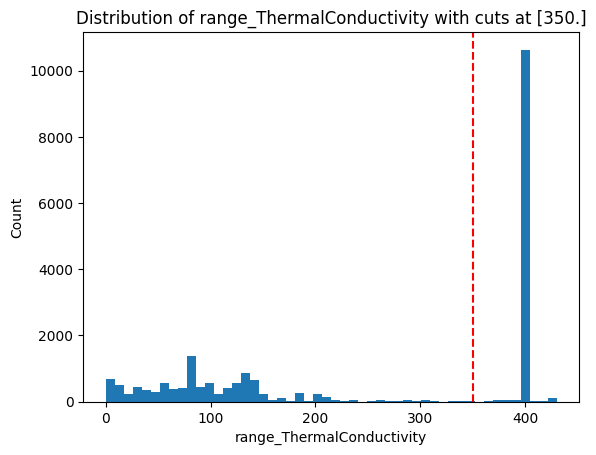

Proportion of observations in each subgroup for feature range_ThermalConductivity:
range_ThermalConductivity
(350.0, 450.0]     0.512157
(-0.001, 350.0]    0.487843
Name: proportion, dtype: float64

Data saved successfully.


In [20]:
data = "data_superconductor"

# download dataset
superconductor = openml.datasets.get_dataset(44148)
X_orig, y, cat_ind, col_names = superconductor.get_data(target=superconductor.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

# save categorical and numerical features
cat_feat_superconductor = []
num_feat_superconductor = X_orig.drop(columns = cat_feat_superconductor).columns.to_numpy()

# process dataset
X, y, subgroups = process_data(X_orig, y, cat_feat_superconductor, num_feat_superconductor)

# subgroup discovery and formation
# 1. manually investigate subgroups
plot_distribution(X, subgroups["importance"], importance_rank=1, cuts=[-0.001, 350, 450])

# 2. manually modify discovered subgroups
bin_df = subgroups["binned_df"].copy(deep=True)
bin_df = modify_subgroups(
    X, bin_df, subgroups["importance"], importance_rank=1, cuts=[-0.001, 350, 450]
)
subgroups["binned_df"] = bin_df

# save data
save_data(X, y, subgroups, dir_path=f"../data/{data}")